# Классификация комментариев

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Цель настоящего проекта — обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построенная нами модель должна выдавать значение метрики качества *F1* не меньше 0.75. 

In [1]:
#загружаем библиотеки
import pandas as pd
import numpy as np
import re
import spacy
import nltk

from spacy.lang.en.examples import sentences
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Подготовка

Для начала посмотрим на данные и подготовим их к дальнейшему обучению моделей.

In [2]:
try:
    data = pd.read_csv('toxic_comments.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [6]:
nltk.download('stopwords') 
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Составим карты слов, которые помогут визуализировать частоту встречаемости некоторых слов в токсичных и нетоксичных комментариях. Начнем с токсичных:

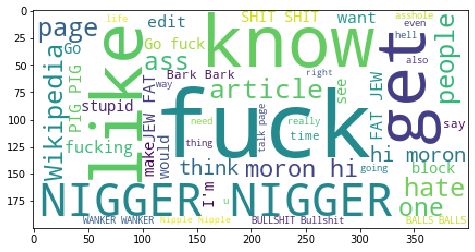

In [7]:
wc = WordCloud(background_color='white', contour_color='white', stopwords=stop_words, max_words=50)

toxic_texts = ". ".join([i for i in data[data['toxic']==1]['text']])
nontoxic_texts = ". ".join([i for i in data[data['toxic']==0]['text']])

fig = plt.figure(figsize=(10,4))
toxic_words = wc.process_text(toxic_texts)
toxic_result = wc.generate_from_frequencies(toxic_words)
plt.imshow(wc);

Видим слова с очевидно негативной коннотацией. Посмотрим на нетоксичные комментарии.

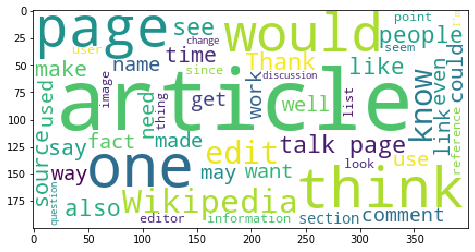

In [8]:
fig = plt.figure(figsize=(10,4))
nontoxic_words = wc.process_text(nontoxic_texts)
nontoxic_result = wc.generate_from_frequencies(nontoxic_words)
plt.imshow(wc);

Здесь слова более нейтральны.

Итак, все тексты находятся в столбце text и нуждаются в лемматизации и очистке от лишних символов. Целевой признак имеет дисбаланс классов: класса 0 в десять раз больше. Начнем с того, что приведем все слова к начальной форме.

In [9]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner', 'tok2vec'])
# создадим функцию для лемматизации
def lemmatize(text):
    tokens = nlp(text)
    lemmas = [token.lemma_ for token in tokens]
    return " ".join(lemmas)

In [10]:
%%time
text_lemmatized = data['text'].apply(lambda x: lemmatize(x))

CPU times: user 18min 15s, sys: 2.27 s, total: 18min 18s
Wall time: 53min 44s


In [11]:
text_lemmatized.head()

0    explanation \n why the edit make under -PRON- ...
1    d'aww ! -PRON- match this background colour -P...
2    hey man , -PRON- be really not try to edit war...
3    " \n More \n -PRON- can not make any real sugg...
4    -PRON- , sir , be -PRON- hero . any chance -PR...
Name: text, dtype: object

Теперь очистим получившиеся тексты от лишних символов.

In [12]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    splitted = text.split()
    return " ".join(splitted)

In [13]:
text_cleared = text_lemmatized.apply(lambda x: clear_text(x))

In [14]:
text_cleared.head()

0    explanation why the edit make under PRON usern...
1    d aww PRON match this background colour PRON b...
2    hey man PRON be really not try to edit war PRO...
3    More PRON can not make any real suggestion on ...
4    PRON sir be PRON hero any chance PRON remember...
Name: text, dtype: object

Мы получили чистые наборы слов для каждого текста, но этого для обучения моделей недостаточно. Есть несколько способов преобразования текстов в машиночитаемый вид. Cейчас активно используются RNN (LSTM) и трансформеры (BERT и ELMO). Но они не являются панацеей и не всегда нужны, так как и TF-IDF (или Word2Veс) + модели из классического ML тоже могут справляться c определенными задачами. Попробуем использовать TF-IDF: этот метод поможет вычислить относительную встречаемость негативно или позитивно окрашенных слов в комментариях и на основе этого показателя определить тональность текста.

Для начала разделим наш датасет на выборки. Тестовая выборка будет составлять 25%.

In [15]:
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(
                                                text_cleared, target, test_size=0.25, stratify=target)
print('Размеры обучающей выборки:', features_train.shape)
print('Размеры валидационной выборки:', features_test.shape)

Размеры обучающей выборки: (119678,)
Размеры валидационной выборки: (39893,)


Теперь полученные выборки трансформируем в разреженные матрицы, в которых будет храниться информация о встречаемости тех или иных слов.

In [16]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

В этом шаге мы произвели предобработку данных и получили две выборки — обучающую и тестовую. В следующем шаге попробуем обучить несколько моделей и посмотреть на их результаты.

## Обучение

В этом шаге обучим следующие модели: логистическую регрессию, решающее дерево и бустинг (light GBM). Затем проверим их работу на тестовой выборке и выберем лучшую.

In [17]:
# Логистическая регрессия
log_parameters = {'C':[0.8, 1]}
log_reg = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=200, class_weight='balanced')
log_grid = GridSearchCV(log_reg, log_parameters, cv=3, verbose=1, iid=False)

log_best = log_grid.fit(features_train, target_train)
log_predictions = log_best.predict(features_train)
log_f1 = f1_score(target_train, log_predictions)

print('F1 логистической регрессии на трейне:', log_f1)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.2min finished


F1 логистической регрессии на трейне: 0.8305732484076433


In [18]:
# Решающее дерево
tree_parameters = {'max_depth':range(10,50,10)}
tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
tree_grid = GridSearchCV(tree, tree_parameters, cv=3, verbose=1, iid=False)

tree_best = tree_grid.fit(features_train, target_train)
tree_predictions = tree_best.predict(features_train)
tree_f1 = f1_score(target_train, tree_predictions)

print('F1 решающего дерева на трейне:', tree_f1)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 16.9min finished


F1 решающего дерева на трейне: 0.5811283075386919


In [19]:
# LightGBM
lgbm_parameters = {'num_leaves': [30, 100], 'max_depth': [10, 50]}
lgbm_clf = lgb.LGBMClassifier(random_state=12345, learning_rate=0.1, class_weight='balanced')
lgbm_grid = GridSearchCV(lgbm_clf, lgbm_parameters, cv=2, verbose=1, iid=False)

lgbm_best = lgbm_grid.fit(features_train, target_train)
lgbm_predictions = lgbm_best.predict(features_train)
lgbm_f1 = f1_score(target_train, lgbm_predictions)

print('F1 бустинга на трейне:', lgbm_f1)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 41.3min finished


F1 бустинга на трейне: 0.8404862500926544


А теперь посмотрим, как модели справятся с тестовой выборкой.

In [22]:
for model, name in zip([tree_best,log_best, lgbm_best], ['дерева', 'лог. регрессии', 'бустинга']):
    predictions = model.predict(features_test)
    model_f1 = f1_score(target_test, predictions)
    print('F1 {} на тесте: {}'.format(name, model_f1))

F1 дерева на тесте: 0.5734565863321228
F1 лог. регрессии на тесте: 0.7507002801120448
F1 бустинга на тесте: 0.7551043686551842


Мы получили результаты работы трех моделей на наших данных, а в следующем шаге проанализируем их.

## Выводы

В настоящем проекте, направленном на создание модели классификации текстов, для преобразования данных мы использовали метод TF-IDF, который позволяет оценить важность слов в тексте. На полученном наборе весов мы обучили три модели — логистическую регрессию, решающее дерево и бустинг. 

Целью проекта было получить показатель метрики f1 не ниже 0,75. Такую метрику удалось получить с помощью бустинга и логрега. Однако время обучения бустинга в три раза превышает время обучения логрега (16 и 5 минут соответственно). Следовательно, поскольку результат моделей не сильно отличается и при наличии у клиента временных ограничений, можно отдать предпочтение логрегу.

В целом, можно говорить о том, что обучение на весах TF-IDF дают удовлетворительный результат при классификации текстов.

In [24]:
games = pd.read_csv('/datasets/games.csv')
games.to_csv('games.csv', index=False)